In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = "/content/drive/MyDrive/Brain Tumour"

FEATURE_PATH = "./features"
MODEL_PATH = "./models"
os.makedirs(FEATURE_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

In [10]:
def get_custom_model(base_model):
    return Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.3)
    ])

def extract_features_and_save(model_name, preprocess_func, base_model):
    gen = ImageDataGenerator(preprocessing_function=preprocess_func)

    train_gen = gen.flow_from_directory(
        os.path.join(DATA_DIR, "Training"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )
    test_gen = gen.flow_from_directory(
        os.path.join(DATA_DIR, "Testing"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    model = get_custom_model(base_model)

    X_train = model.predict(train_gen, verbose=1)
    X_test = model.predict(test_gen, verbose=1)
    y_train = train_gen.classes
    y_test = test_gen.classes

    np.save(f"{FEATURE_PATH}/{model_name}_X_train.npy", X_train)
    np.save(f"{FEATURE_PATH}/{model_name}_X_test.npy", X_test)
    np.save(f"{FEATURE_PATH}/{model_name}_y_train.npy", y_train)
    np.save(f"{FEATURE_PATH}/{model_name}_y_test.npy", y_test)

    return X_train, y_train, X_test, y_test

In [32]:
def train_and_save_ml_ensemble(X_train, y_train, X_test, y_test, model_name):
    clf1 = SVC(kernel='linear', probability=True)
    clf2 = RandomForestClassifier(n_estimators=100)
    clf3 = LogisticRegression(max_iter=1000)

    ensemble = VotingClassifier(
        estimators=[('svm', clf1), ('rf', clf2), ('lr', clf3)],
        voting='soft'
    )
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    joblib.dump(ensemble, f"{MODEL_PATH}/{model_name}_ensemble.pkl")

    acc = accuracy_score(y_test, y_pred)
    print(f"\n {model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    return ensemble, y_pred, acc, y_test

In [33]:
# VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
X_train_vgg, y_train, X_test_vgg, y_test = extract_features_and_save("VGG16", vgg_preprocess, vgg_base)
vgg_model, y_pred_vgg, acc_vgg, _ = train_and_save_ml_ensemble(X_train_vgg, y_train, X_test_vgg, y_test, "VGG16")

# ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
X_train_resnet, _, X_test_resnet, _ = extract_features_and_save("ResNet50", resnet_preprocess, resnet_base)
resnet_model, y_pred_resnet, acc_resnet, _ = train_and_save_ml_ensemble(X_train_resnet, y_train, X_test_resnet, y_test, "ResNet50")

# MobileNetV2
mobile_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
X_train_mobile, _, X_test_mobile, _ = extract_features_and_save("MobileNetV2", mobilenet_preprocess, mobile_base)
mobile_model, y_pred_mobile, acc_mobile, _ = train_and_save_ml_ensemble(X_train_mobile, y_train, X_test_mobile, y_test, "MobileNetV2")


Found 5712 images belonging to 4 classes.
Found 1329 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 180ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step

 VGG16 Accuracy: 0.9503
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       308
           1       0.89      0.92      0.90       306
           2       0.99      1.00      0.99       415
           3       0.97      0.97      0.97       300

    accuracy                           0.95      1329
   macro avg       0.95      0.95      0.95      1329
weighted avg       0.95      0.95      0.95      1329

Found 5712 images belonging to 4 classes.
Found 1329 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step

 ResNet50 Accuracy: 0.9594
              precision    recall  f1-score   support

           0       0.97      0.88      0.93       308
           1       0.88      0.96      0.92       306
           2       1.00      1.00      1.00       415
           3       0.98      0.98      0.98       300

    accuracy                           0.96      1329
   macro avg       0.96      0.96      0.96      1329
weighted avg       0.96      0.96      0.96      1329

Found 5712 images belonging to 4 classes.
Found 1329 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step

 MobileNetV2 Accuracy: 0.9518
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       308
           1       0.87      0.93      0.90       306
           2       0.99      1.00      1.00       415
           3       0.96      0.98      0.97       300

    accuracy                           0.95      1329
   macro avg       0.95      0.95      0.95      1329
weighted avg       0.95      0.95      0.95      1329



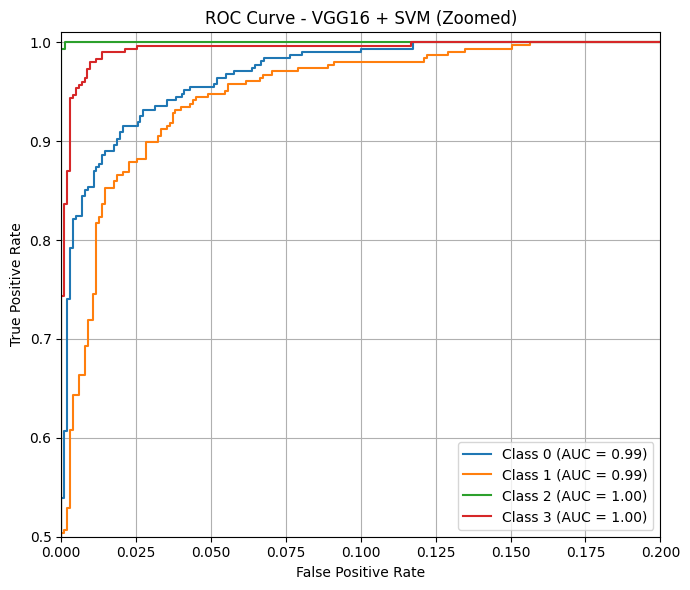

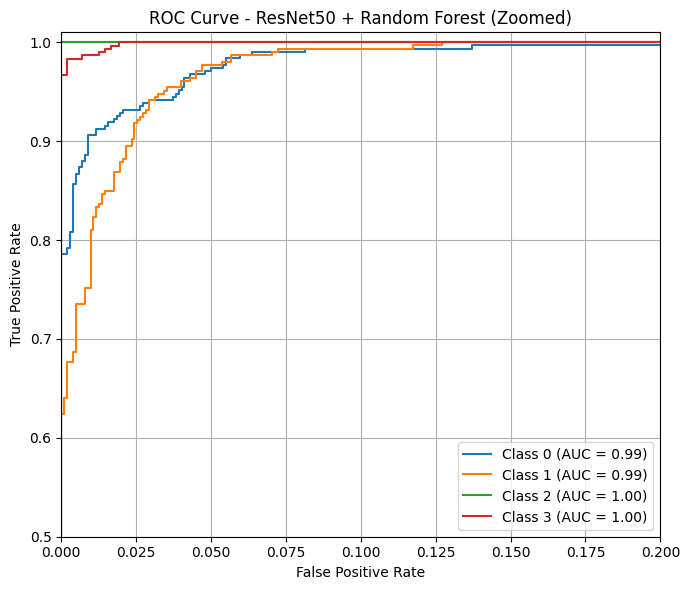

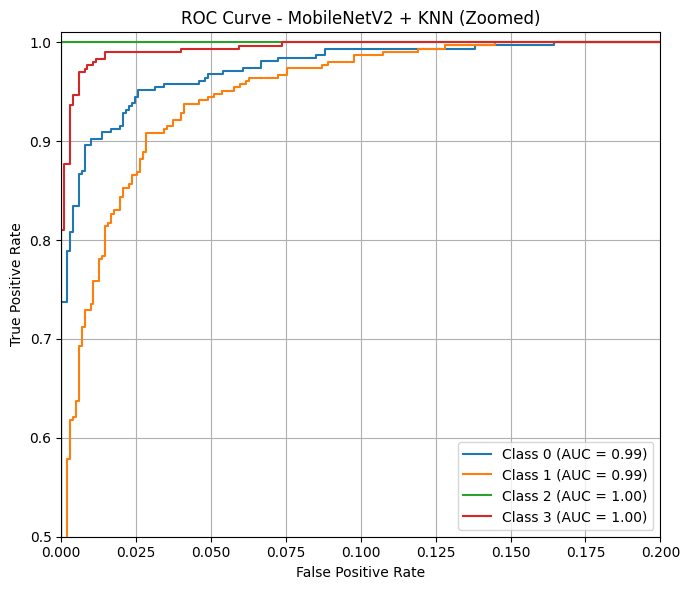

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

def plot_roc(y_test_bin, y_score, model_name, zoom=False):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(7, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    if zoom:
        plt.xlim([0.0, 0.2])
        plt.ylim([0.5, 1.01])
    else:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {model_name}" + (" (Zoomed)" if zoom else ""))
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# VGG16 + SVM
vgg_preds_proba = vgg_model.predict_proba(X_test_vgg)
plot_roc(y_test_bin, vgg_preds_proba, "VGG16 + SVM", zoom=True)

# ResNet50 + RF
resnet_preds_proba = resnet_model.predict_proba(X_test_resnet)
plot_roc(y_test_bin, resnet_preds_proba, "ResNet50 + Random Forest", zoom=True)

# MobileNetV2 + KNN
mobile_preds_proba = mobile_model.predict_proba(X_test_mobile)
plot_roc(y_test_bin, mobile_preds_proba, "MobileNetV2 + KNN", zoom=True)

In [35]:
X_train_fused = np.concatenate([X_train_vgg, X_train_resnet, X_train_mobile], axis=1)
X_test_fused = np.concatenate([X_test_vgg, X_test_resnet, X_test_mobile], axis=1)
fused_model, y_pred_fused, acc_fused, y_test_fused = train_and_save_ml_ensemble(X_train_fused, y_train, X_test_fused, y_test, "Fused")


 Fused Accuracy: 0.9752
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       308
           1       0.92      0.98      0.95       306
           2       1.00      1.00      1.00       415
           3       0.98      0.99      0.99       300

    accuracy                           0.98      1329
   macro avg       0.97      0.97      0.97      1329
weighted avg       0.98      0.98      0.98      1329



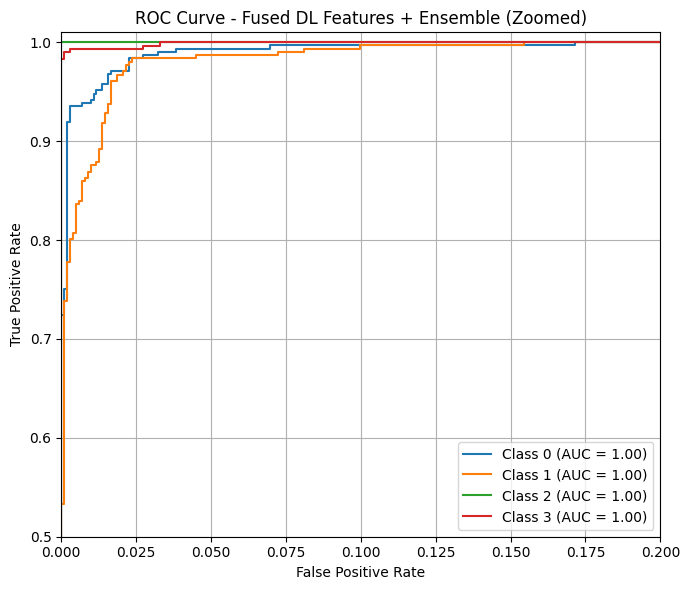

In [36]:
fused_preds_proba = fused_model.predict_proba(X_test_fused)
plot_roc(y_test_bin, fused_preds_proba, "Fused DL Features + Ensemble",zoom=True)

In [37]:
accuracies = {
    "VGG16": acc_vgg,
    "ResNet50": acc_resnet,
    "MobileNetV2": acc_mobile,
    "Fused": acc_fused
}

print("\n Accuracy Summary:")
for k, v in accuracies.items():
    print(f"{k}: {v:.4f}")



 Accuracy Summary:
VGG16: 0.9503
ResNet50: 0.9594
MobileNetV2: 0.9518
Fused: 0.9752


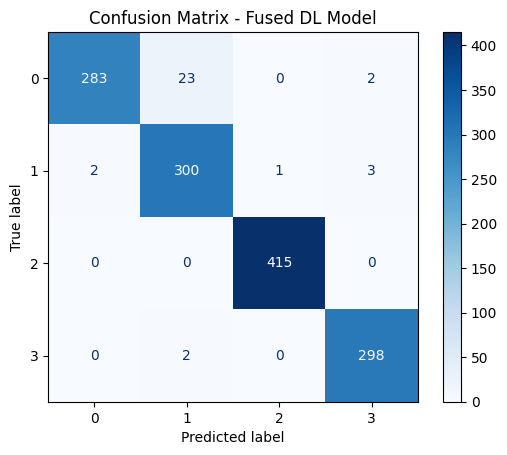

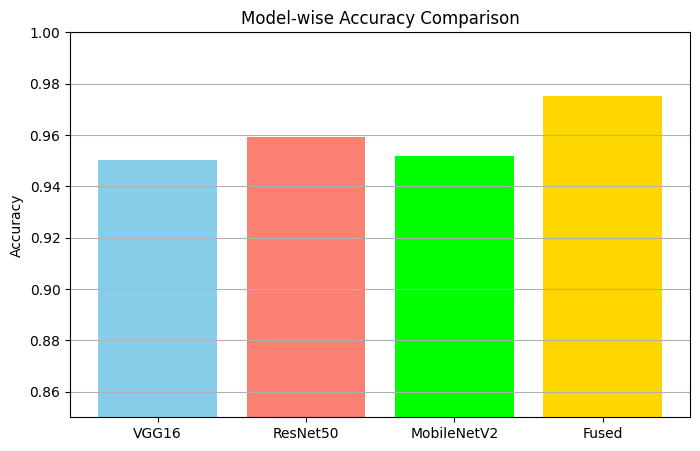

In [38]:
# Confusion Matrix - Fused
ConfusionMatrixDisplay.from_predictions(y_test_fused, y_pred_fused, cmap='Blues')
plt.title("Confusion Matrix - Fused DL Model")
plt.show()

# Accuracy Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'salmon', 'lime', 'gold'])
plt.title("Model-wise Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1.0)
plt.grid(axis='y')
plt.show()



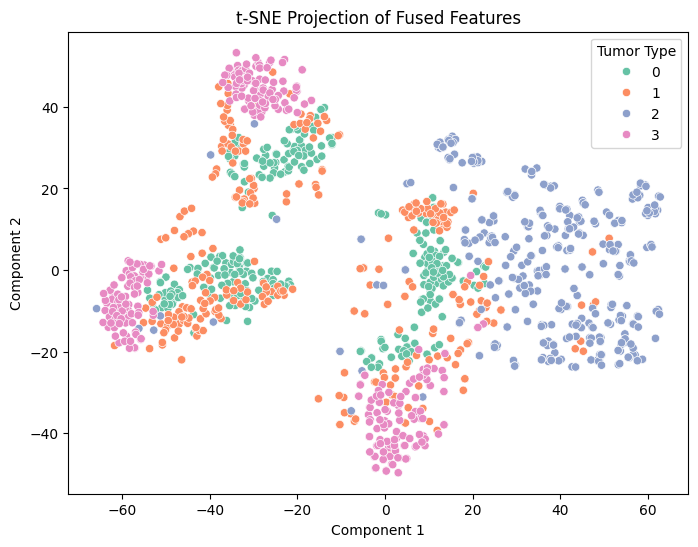

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
fused_2d = tsne.fit_transform(X_test_fused)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fused_2d[:, 0], y=fused_2d[:, 1], hue=y_test_fused, palette="Set2")
plt.title("t-SNE Projection of Fused Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Tumor Type")
plt.show()


 Brain Tumor Detection System with Explainability
 Enter the full path to the MRI image:  /content/drive/MyDrive/Brain Tumour/Training/pituitary/Tr-piTr_0000.jpg


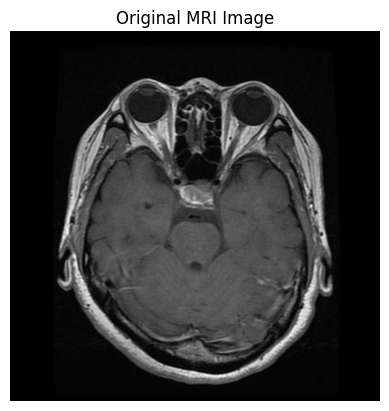

 Predicted Tumor Type: Pituitary Tumor
 Explanation: Pituitary tumors occur at the base of the brain and may affect hormone levels or vision.


In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preproc
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preproc
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preproc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import joblib
import cv2

def get_feature_extractor(base_model, name):
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return Model(inputs=base_model.input, outputs=x, name=name)

vgg_model = get_feature_extractor(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), "VGG16")
resnet_model = get_feature_extractor(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), "ResNet50")
mobile_model = get_feature_extractor(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), "MobileNetV2")

fused_model = joblib.load('/content/drive/MyDrive/models/Fused_ensemble.pkl')

class_info = {
    0: ("Glioma Tumor", "Gliomas are aggressive brain tumors arising from glial cells. They may require surgery, radiation, or chemo."),
    1: ("Meningioma Tumor", "Meningiomas are tumors from the brain’s protective layers, usually benign but may need removal."),
    2: ("No Tumor", "The scan is clear. No brain tumor is detected."),
    3: ("Pituitary Tumor", "Pituitary tumors occur at the base of the brain and may affect hormone levels or vision.")
}

def extract_features_from_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)

    vgg_feat = vgg_model.predict(vgg_preproc(img_expanded), verbose=0)
    resnet_feat = resnet_model.predict(resnet_preproc(img_expanded), verbose=0)
    mobile_feat = mobile_model.predict(mobile_preproc(img_expanded), verbose=0)

    fused_features = np.concatenate([
        vgg_feat.flatten(),
        resnet_feat.flatten(),
        mobile_feat.flatten()
    ]).reshape(1, -1)

    return fused_features, img_array.astype('uint8'), resnet_preproc(img_expanded)

def predict_and_explain(img_path):
    features, _, _ = extract_features_from_image(img_path)

    prediction = fused_model.predict(features)
    predicted_label = prediction[0]
    tumor_name, explanation = class_info.get(predicted_label, ("Unknown", "No explanation available."))

    original_img = cv2.imread(img_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    plt.imshow(original_img_rgb)
    plt.axis('off')
    plt.title("Original MRI Image")
    plt.show()

    print(f" Predicted Tumor Type: {tumor_name}")
    print(f" Explanation: {explanation}")

if __name__ == "__main__":
    print(" Brain Tumor Detection System with Explainability")
    img_path = input(" Enter the full path to the MRI image: ").strip()

    if os.path.exists(img_path) and img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        predict_and_explain(img_path)
    else:
        print(" Invalid path or file format. Please enter a valid image path (JPG/PNG).")
